In [22]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('../data/nfp2/nfp2.db')  # Adjust the path to your database file

# Step 2 & 3: Query the database and load the data into a pandas DataFrame
query = "SELECT * FROM stellarators"  # Adjust your query as needed
data_df = pd.read_sql_query(query, conn)

In [23]:
from sklearn.model_selection import train_test_split, GridSearchCV

data_df_clean = data_df.dropna(subset=['quasisymmetry'])

X = data_df_clean[['rbc_1_0', 'rbc_m1_1', 'rbc_0_1', 'rbc_1_1','zbs_1_0', 'zbs_m1_1', 'zbs_0_1', 'zbs_1_1']] 
Y = data_df_clean[['quasisymmetry', 'quasiisodynamic', 'rotational_transform', 'inverse_aspect_ratio', 'mean_local_magnetic_shear', 'vacuum_magnetic_well', 'maximum_elongation', 'mirror_ratio']]

target = X['rbc_1_0']
features = X.drop('rbc_1_0', axis=1)

quasisymmetry_df = pd.DataFrame(Y['quasisymmetry'])

features = pd.concat([features, quasisymmetry_df], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.2, random_state=42)


Fitting of candidate distributions completed: 100%|██████████| 8/8 [00:21<00:00,  2.65s/it]


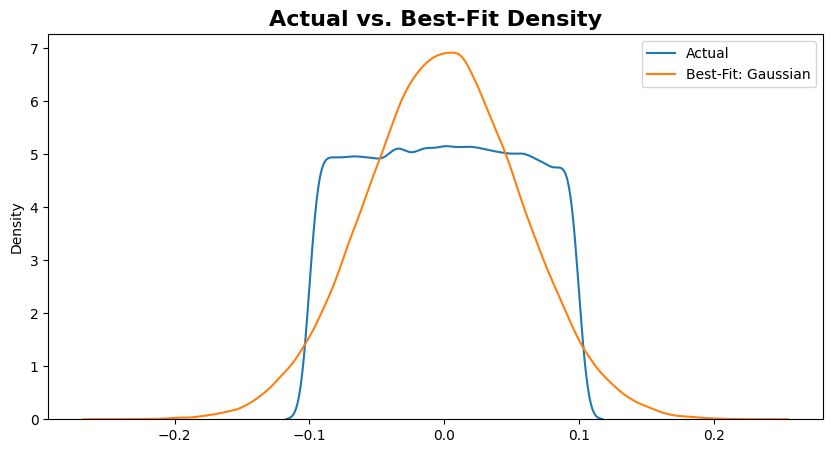

Index(['rbc_m1_1', 'rbc_0_1', 'rbc_1_1', 'zbs_1_0', 'zbs_m1_1', 'zbs_0_1',
       'zbs_1_1', 'quasisymmetry'],
      dtype='object')


In [24]:
from lightgbmlss.distributions import *
from lightgbmlss.distributions.distribution_utils import DistributionClass
import numpy as np

Y_train_np = np.array(Y_train)

lgblss_dist_class = DistributionClass()
candidate_distributions = [Gaussian, StudentT, Gamma, Cauchy, LogNormal, Weibull, Gumbel, Laplace]

dist_nll = lgblss_dist_class.dist_select(target=Y_train, candidate_distributions=candidate_distributions, max_iter=50, plot=True, figure_size=(10, 5))
dist_nll

este grafico apenas ve a distribuição da target variable?

In [31]:
from lightgbmlss.model import *
from lightgbmlss.distributions.Gaussian import *

dtrain = lgb.Dataset(X_train, label=Y_train_np)

lgblss = LightGBMLSS(
    Gaussian(stabilization="None",  
             response_fn="exp",      
             loss_fn="nll"          
            ))

param_dict = {
    "rbc_m1_1":                ["float", {"low": -1,   "high": 1,     "log": False}],
    "rbc_0_1":                 ["float", {"low": -1,   "high": 1,     "log": False}],
    "rbc_1_1":                 ["float", {"low": -1,   "high": 1,     "log": False}],
    "zbs_1_0":                 ["float", {"low": -1,   "high": 1,     "log": False}],
    "zbs_m1_1":                ["float", {"low": -1,   "high": 1,     "log": False}],
    "zbs_0_1":                 ["float", {"low": -1,   "high": 1,     "log": False}],
    "zbs_1_1":                 ["float", {"low": -1,   "high": 1,     "log": False}],
    "quasisymmetry":           ["float", {"low": 0.01,    "high": 10,    "log": True}],
    "max_depth":               ["int",   {"low": 1,    "high": 10,    "log": False}],
    "num_leaves":              ["int",   {"low": 1,    "high": 100,   "log": False}],  
    "min_data_in_leaf":        ["int",   {"low": 200,  "high": 200,   "log": False}],  
    "min_gain_to_split":       ["float", {"low": 1, "high": 40,    "log": False}],
    "min_sum_hessian_in_leaf": ["float", {"low": 1, "high": 500,   "log": True}],
    "subsample":               ["float", {"low": 0.2,  "high": 1.0,   "log": False}],
    "feature_fraction":        ["float", {"low": 0.2,  "high": 1.0,   "log": False}],
    "boosting":                ["categorical", ["gbdt"]],
}

np.random.seed(123)
opt_param = lgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=100,        # Number of boosting iterations.
                             nfold=5,                    # Number of cv-folds.
                             early_stopping_rounds=20,   # Number of early-stopping rounds
                             max_minutes=10,             # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=30 ,               # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=True,               # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=123                 # Seed for random number generator used in the Bayesian hyperparameter search.
                            )

Best trial: 14. Best value: -29708.5: 100%|██████████| 30/30 [01:03<00:00,  2.11s/it, 63.27/600 seconds]


Hyper-Parameter Optimization successfully finished.
  Number of finished trials:  30
  Best trial:
    Value: -29708.48705960461
    Params: 
    rbc_m1_1: 0.1930847306311837
    rbc_0_1: -0.6087786309248994
    rbc_1_1: 0.11378958954390987
    zbs_1_0: 0.6199266977208575
    zbs_m1_1: 0.6928887853339982
    zbs_0_1: 0.9712342338115196
    zbs_1_1: -0.6454230103560358
    quasisymmetry: 0.0984642913342421
    max_depth: 7
    num_leaves: 49
    min_data_in_leaf: 200
    min_gain_to_split: 1.403565120029494
    min_sum_hessian_in_leaf: 477.1406240071067
    subsample: 0.7882812634950184
    feature_fraction: 0.8025437602799832
    boosting: gbdt
    opt_rounds: 5


In [32]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyperparameters
lgblss.train(opt_params, dtrain, num_boost_round=n_rounds)

# Set seed for reproducibility
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = 1000
quant_sel = [0.05, 0.95] # Quantiles to calculate from predicted distribution

# Sample from predicted distribution
pred_samples = lgblss.predict(X_test,
                              pred_type="samples",
                              n_samples=n_samples,
                              seed=123)

# Calculate quantiles from predicted distribution
pred_quantiles = lgblss.predict(X_test,
                                pred_type="quantiles",
                                n_samples=n_samples,
                                quantiles=quant_sel)

# Return predicted distributional parameters
pred_params = lgblss.predict(X_test,
                             pred_type="parameters")

In [33]:
pred_samples.head()

,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,y_sample9,...,y_sample990,y_sample991,y_sample992,y_sample993,y_sample994,y_sample995,y_sample996,y_sample997,y_sample998,y_sample999
0,0.019457,0.032853,-0.031993,-0.038430,-0.084393,0.043136,0.043798,-0.046233,-0.042427,-0.095806,...,0.113627,-0.019666,0.141569,-0.026237,0.060414,-0.041571,0.028758,-0.057843,0.044142,-0.086481
1,-0.010785,0.105779,-0.038134,-0.005851,-0.000851,-0.005572,0.061853,-0.007514,-0.075380,0.107399,...,0.041006,0.007931,0.065953,-0.094783,0.029519,-0.049937,-0.145336,0.044475,0.045002,-0.082578
2,-0.017189,0.030715,-0.092157,-0.014644,0.003418,0.122379,0.034926,-0.025372,-0.084066,0.041826,...,0.057250,-0.050799,-0.000230,0.114290,0.013691,0.007188,0.016902,0.198272,-0.089834,0.137190
3,-0.035401,-0.099113,0.032725,-0.024410,0.009863,-0.052166,-0.011294,0.059491,-0.120059,0.032583,...,-0.031639,-0.084368,0.001148,0.024673,0.018014,-0.046304,0.038601,0.024634,0.067872,-0.072588
4,0.017886,-0.045229,0.003080,-0.052753,0.005550,0.051432,0.084931,0.107431,0.037231,-0.031957,...,-0.044139,0.025378,0.005630,0.019796,-0.060660,0.029201,-0.007466,-0.002582,-0.005151,0.005855


In [29]:
pred_quantiles.head()

,quant_0.05,quant_0.95
0,-0.096976,0.093570
1,-0.094493,0.096919
2,-0.093576,0.101569
3,-0.098013,0.095767
4,-0.097200,0.099353


In [37]:
pred_params.head()

,loc,scale
0,0.000099,0.057378
1,-0.000707,0.056687
2,0.000330,0.057716
3,-0.001490,0.057671
4,-0.002500,0.058480


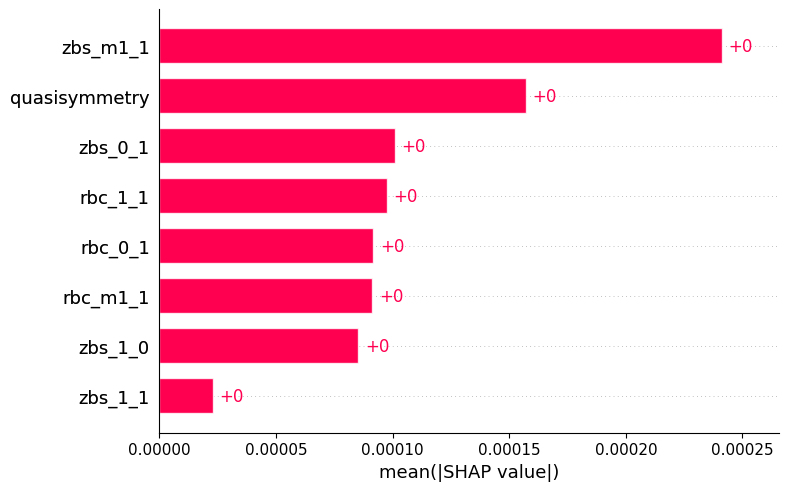

In [39]:
# Feature Importance of scale parameter
lgblss.plot(X_test,
            parameter="scale",
            plot_type="Feature_Importance")